### 개선방향
- `04_02_FE_shop_cats.ipynb`에서 전처리를 완료한 데이터를 사용하여 LightGBM을 학습
- 과적합을 줄이기 위한 하이퍼 파라미터를 추가하여 최적화

# Module

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.samplers import TPESampler
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

# Data

In [6]:
data_path = "./data/"

all_data = joblib.load(data_path + 'all_data2.joblib')
sub = pd.read_csv(data_path + 'sample_submission.csv')

In [7]:
all_data.shape

(8812244, 37)

# Model

## prepare

In [8]:
x_train = all_data[all_data['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis=1)

x_val = all_data[all_data['date_block_num'] == 33]
x_val = x_val.drop(['item_cnt_month'], axis=1)

x_test = all_data[all_data['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis=1)

y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
y_val = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

x_all = pd.concat([x_train, x_val])
y_all = pd.concat([y_train, y_val])

x_sample = all_data[(all_data['date_block_num'] > 12)&(all_data['date_block_num'] < 33)]
x_sample = x_sample.drop(['item_cnt_month'], axis=1)
y_sample = all_data[(all_data['date_block_num'] > 12)&(all_data['date_block_num'] < 33)]['item_cnt_month']

del all_data

In [5]:
x_sample.shape, y_sample.shape

((4755902, 36), (4755902,))

In [9]:
cat_features = ['shop_id', 'type', 'subtype', 'shop_type', 'shop_category', 'item_category_id', 'city', 'month']

dtrain = lgb.Dataset(x_sample, y_sample, categorical_feature=cat_features)
dval = lgb.Dataset(x_val, y_val, categorical_feature=cat_features, reference=dtrain)

- 하이퍼 파라미터 최적화 과정에서 일부 데이터만 활용

## optuna
- 과적합을 줄이기 위해 `max_depth`, `min_child_samples`, `reg_alpha`, `reg_lambda`를 추가

In [10]:
%%time

fixed_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'force_col_wise': True,
    'random_state': 2025,
    'verbosity': -1,
    'feature_pre_filter': False
}

def objective_lgbm(trial):
    params = {
        **fixed_params,
        'num_leaves': trial.suggest_int('num_leaves', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'max_depth': trial.suggest_int('max_depth', 7, 15), 
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'rmse', valid_name='eval')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=1500,
        valid_sets=[dval],
        valid_names=['eval'],
        callbacks=[
            early_stopping(stopping_rounds=300, verbose=False),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    trial.set_user_attr("best_iter", lgb_model.best_iteration)
    
    preds = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return rmse 


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30, show_progress_bar=True)

[I 2025-12-03 02:26:32,997] A new study created in memory with name: no-name-0678a10e-d9e2-49c2-9f80-aa54391e5536


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-03 02:28:53,070] Trial 0 finished with value: 0.7832095247217823 and parameters: {'num_leaves': 154, 'learning_rate': 0.059662768998574464, 'feature_fraction': 0.9663028199432513, 'bagging_fraction': 0.7227840820237976, 'bagging_freq': 4, 'max_depth': 9, 'min_child_samples': 73, 'reg_alpha': 0.0002713641282671901, 'reg_lambda': 4.76590930239128}. Best is trial 0 with value: 0.7832095247217823.
[I 2025-12-03 02:34:46,446] Trial 1 finished with value: 0.7803499558832495 and parameters: {'num_leaves': 421, 'learning_rate': 0.008135993077935482, 'feature_fraction': 0.9005290432959974, 'bagging_fraction': 0.5208589864093756, 'bagging_freq': 8, 'max_depth': 7, 'min_child_samples': 43, 'reg_alpha': 0.0031494084907373074, 'reg_lambda': 1.6490982194987314}. Best is trial 1 with value: 0.7803499558832495.
[I 2025-12-03 02:44:31,004] Trial 2 finished with value: 0.7792494371011645 and parameters: {'num_leaves': 220, 'learning_rate': 0.0031419355583659327, 'feature_fraction': 0.83319605

In [11]:
print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Iteration : {study_lgbm.best_trial.user_attrs['best_iter']}')
print(f'Best Score : {study_lgbm.best_value:.5f}')
print('=='*20,'Best Parameters', '=='*20)
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

Total Trials : 30
Best Trial : 3
Best Iteration : 1500
Best Score : 0.77662
======================================== Best Parameters ========================================
num_leaves : 308
learning_rate : 0.0020393416894354194
feature_fraction : 0.5073136764121102
bagging_fraction : 0.6621216032047456
bagging_freq : 10
max_depth : 11
min_child_samples : 90
reg_alpha : 4.0416780890110164e-08
reg_lambda : 3.6089730120097523e-06


/tmp/ipykernel_28520/1748665859.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study_lgbm)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

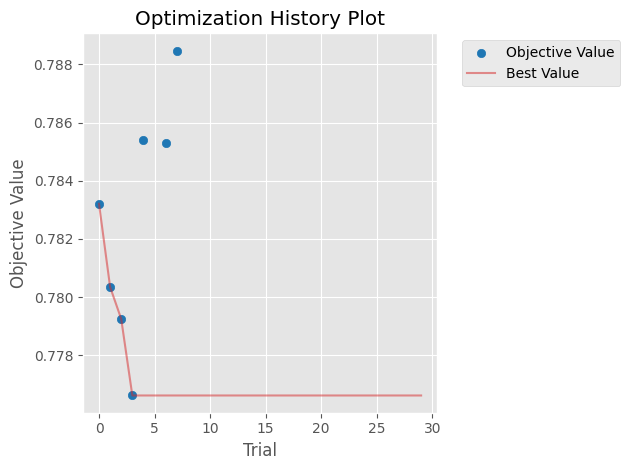

In [12]:
plot_optimization_history(study_lgbm)

/tmp/ipykernel_28520/3004270277.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study_lgbm)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

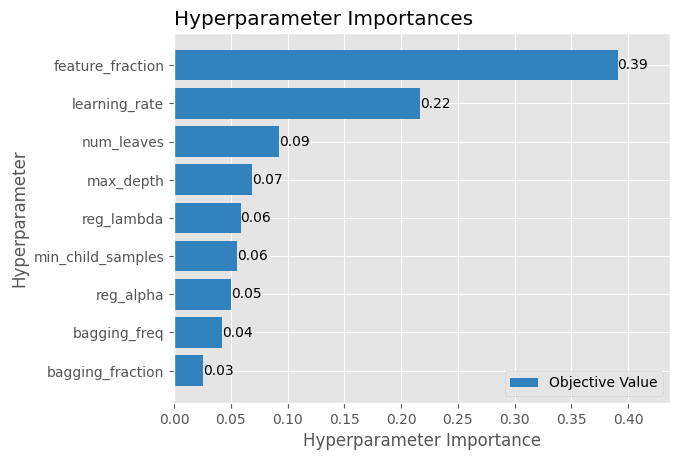

In [13]:
plot_param_importances(study_lgbm)

## train

In [14]:
best_params = study_lgbm.best_params
best_params.update(fixed_params)
best_iter = study_lgbm.best_trial.user_attrs['best_iter']

In [15]:
dtrain_all = lgb.Dataset(x_all, y_all, categorical_feature=cat_features)
final_iter = int(best_iter * 1.3)

In [16]:
%%time

final_lgbm_model = lgb.train(
    params=best_params,
    train_set=dtrain_all,
    num_boost_round=final_iter,
    valid_sets=[dtrain_all],
    callbacks=[
        log_evaluation(period=100)
    ]
)

[100]	training's rmse: 1.13921
[200]	training's rmse: 1.06914
[300]	training's rmse: 1.01656
[400]	training's rmse: 0.976865
[500]	training's rmse: 0.946867
[600]	training's rmse: 0.924747
[700]	training's rmse: 0.90752
[800]	training's rmse: 0.894352
[900]	training's rmse: 0.884068
[1000]	training's rmse: 0.875443
[1100]	training's rmse: 0.868793
[1200]	training's rmse: 0.863049
[1300]	training's rmse: 0.858023
[1400]	training's rmse: 0.853826
[1500]	training's rmse: 0.850068
[1600]	training's rmse: 0.846726
[1700]	training's rmse: 0.843791
[1800]	training's rmse: 0.841144
[1900]	training's rmse: 0.838758
CPU times: user 1h 18min 11s, sys: 11.8 s, total: 1h 18min 22s
Wall time: 20min 45s


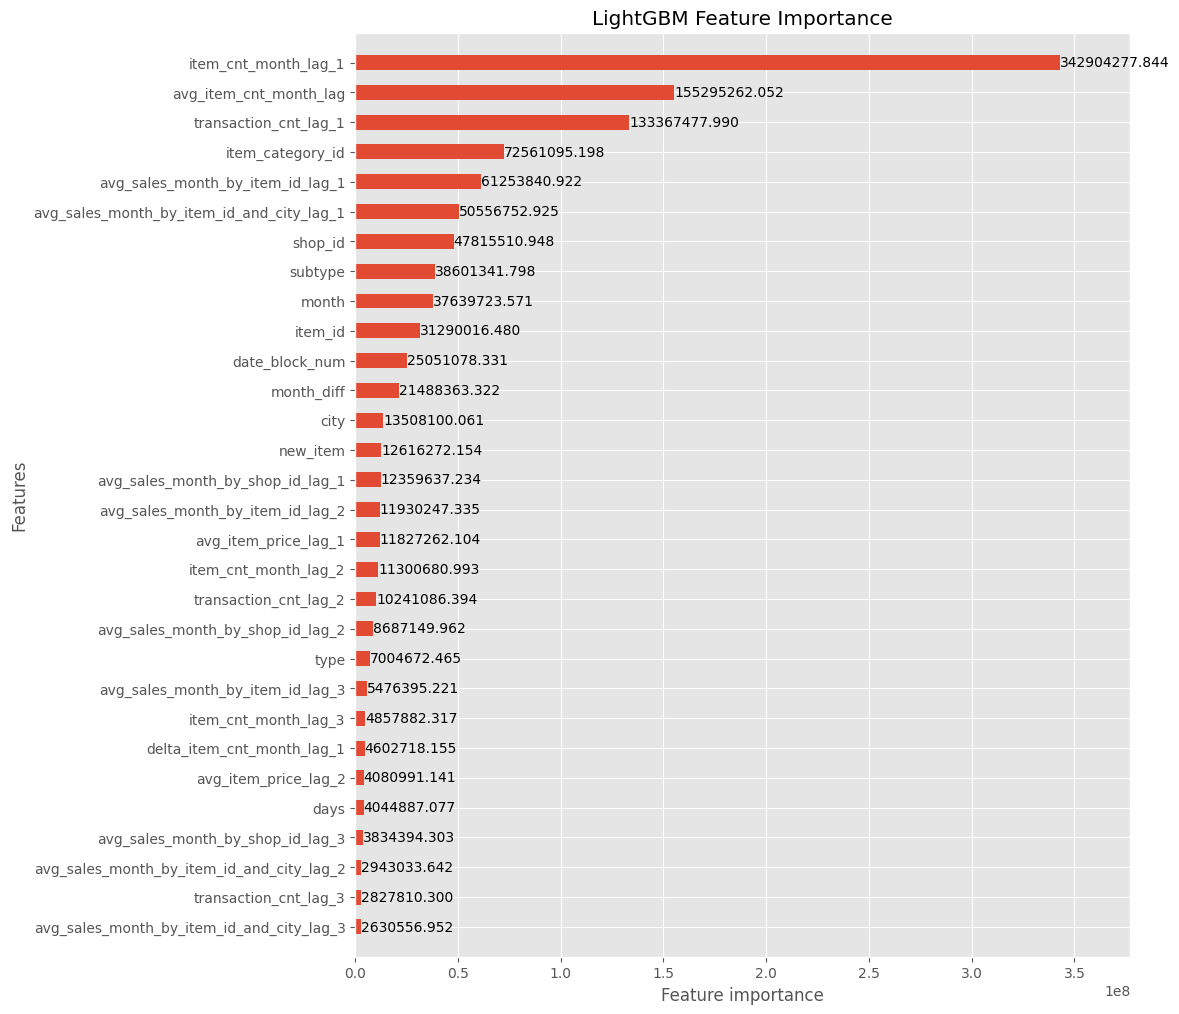

In [17]:
plt.figure(figsize=(10, 12)) 
lgb.plot_importance(final_lgbm_model, max_num_features=30, height=0.5, ax=plt.gca(), importance_type='gain')
plt.title('LightGBM Feature Importance')
plt.show()

In [18]:
final_lgbm_model.save_model(data_path + '05_lgbm_model_regs.txt')

## prediction

In [15]:
final_lgbm_model = lgb.Booster(model_file='./data/05_lgbm_model_regs.txt')

In [16]:
predictions = final_lgbm_model.predict(x_test).clip(0, 20)
sub['item_cnt_month'] = predictions
sub.head()

,ID,item_cnt_month
0,0,0.440780
1,1,0.363129
2,2,0.813796
3,3,0.378212
4,4,2.858373


In [17]:
print(pd.Series(predictions).describe())

count    214200.000000
mean          0.291126
std           0.798532
min           0.000000
25%           0.035570
50%           0.089414
75%           0.246657
max          19.908370
dtype: float64


In [10]:
sub.to_csv(data_path + '05_submission_lgbm_regs.csv', index=False)

In [11]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f "./data/05_submission_lgbm_regs.csv" -m "05_submission_lgbm_regs2"

100%|██████████████████████████████████████| 5.39M/5.39M [00:00<00:00, 11.8MB/s]
Successfully submitted to Predict Future Sales

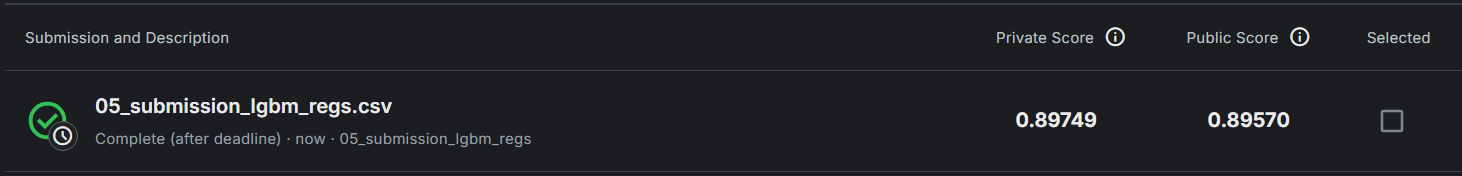
- 학습단계의 스코어와 private score의 차이가 줄어듦. private score 기준 0.85988에서 0.89749로 성능이 하락